In [1]:
from langchain_community.document_loaders import (
    PyPDFLoader,
    PyMuPDFLoader
)

In [2]:
from langchain_community.document_loaders import PyMuPDFLoader
import glob
import os

# Define the directory path
directory_path = r"C:\Users\Shaur\OneDrive\Desktop\ML\insurance"

# Use glob to find all PDF files in the directory
pdf_files = glob.glob(os.path.join(directory_path, "*.pdf"))

# List to hold all documents from all PDFs
all_documents = []

# Loop through each PDF file and load it
for pdf_file in pdf_files:
    print(f"Loading file: {pdf_file}")
    loader = PyMuPDFLoader(pdf_file)
    documents = loader.load()
    all_documents.extend(documents)

# Print basic information about the loaded documents
print("\n--- Summary ---")
print(f"Number of documents (pages) loaded: {len(all_documents)}")
if all_documents:
    print(f"First page content preview: {all_documents[30].page_content[:200]}...")
    print(f"Metadata of the first page: {all_documents[0].metadata}")

Loading file: C:\Users\Shaur\OneDrive\Desktop\ML\insurance\icici_car.pdf
Loading file: C:\Users\Shaur\OneDrive\Desktop\ML\insurance\lic_health.pdf
Loading file: C:\Users\Shaur\OneDrive\Desktop\ML\insurance\newdeldi_home.pdf

--- Summary ---
Number of documents (pages) loaded: 60
First page content preview: LIC’s New Jeevan Amar (512N350V01)                                                       Page 7 of 15 
                                        
 
 
The Death Benefit shall be paid in lump sum as speci...
Metadata of the first page: {'producer': 'Corel PDF Engine Version 16.0.0.707', 'creator': 'CorelDRAW X6', 'creationdate': '2018-04-07T13:58:32+05:30', 'source': 'C:\\Users\\Shaur\\OneDrive\\Desktop\\ML\\insurance\\icici_car.pdf', 'file_path': 'C:\\Users\\Shaur\\OneDrive\\Desktop\\ML\\insurance\\icici_car.pdf', 'total_pages': 24, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-06-13T12:18:25+05:30', 'trapped': '', 'modDate': "D:20240613

In [3]:
import re

def clean_pdf_text(text: str) -> str:

    # Remove non-ASCII characters
    text = text.encode("ascii", "ignore").decode()

    # Replace multiple spaces/newlines with single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading/trailing spaces
    text = text.strip()

    return text


In [7]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)
print(embeddings)


[[ 0.02250255 -0.0782917  -0.02303072 ... -0.00827934  0.02652687
  -0.00201892]
 [ 0.04170233  0.00109746 -0.01553418 ... -0.02181629 -0.06359357
  -0.00875288]]


In [10]:
from langchain_experimental.text_splitter import SemanticChunker
from sentence_transformers import SentenceTransformer
from langchain_community.embeddings import HuggingFaceEmbeddings

# Use SentenceTransformer model
model_name = 'sentence-transformers/all-mpnet-base-v2'
embedding_model = HuggingFaceEmbeddings(model_name=model_name)

# Initialize SemanticChunker
text_splitter = SemanticChunker(
    embedding_model,
    breakpoint_threshold_type="gradient",   
    breakpoint_threshold_amount=90
)


C:\Users\Shaur\AppData\Local\Temp\ipykernel_3004\3160985490.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name=model_name)


In [11]:
chunks = text_splitter.split_documents(all_documents)

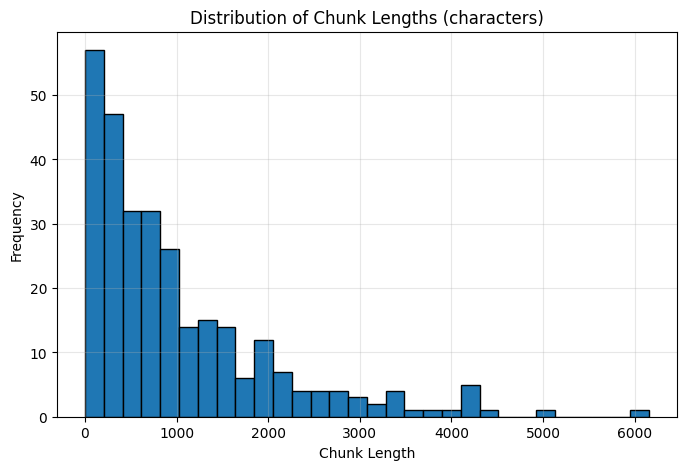

Total chunks: 294
Average length: 1007.3 characters


In [13]:
from matplotlib import pyplot as plt
chunk_lengths = [len(chunk.page_content) for chunk in chunks]

# 6. Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(chunk_lengths, bins=30, edgecolor='black')
plt.title("Distribution of Chunk Lengths (characters)")
plt.xlabel("Chunk Length")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Display summary
print(f"Total chunks: {len(chunk_lengths)}")
print(f"Average length: {sum(chunk_lengths)/len(chunk_lengths):.1f} characters")

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

char_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500, 
    chunk_overlap=100
)

final_chunks = []
for chunk in chunks:
    text = chunk.page_content
    if len(text) > 2000: 
        sub_chunks = char_splitter.split_text(text)
        final_chunks.extend(sub_chunks)
    else:
        final_chunks.append(text)


In [16]:
from langchain.schema import Document
final_documents = [Document(page_content=t) for t in final_chunks]
len(final_documents)


358

In [17]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
# from sentence_transformers import SentenceTransformer # Not needed directly

# 1. FIX: Use HuggingFaceEmbeddings to wrap the SentenceTransformer model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Create a ChromaDB vector store
persist_directory = r"C:\Users\Shaur\OneDrive\Desktop\ML\RAG\chroma_db1"

vectorstore = Chroma.from_documents(
    documents=final_documents,# Use the list with correct metadata
    embedding=embeddings, # Pass the LangChain-compatible object
    persist_directory=persist_directory,
    collection_name="rag_collection"
)

print(f"Vector store created with {vectorstore._collection.count()} vectors")
print(f"Persisted to: {persist_directory}")

Vector store created with 606 vectors
Persisted to: C:\Users\Shaur\OneDrive\Desktop\ML\RAG\chroma_db1


In [18]:
import os
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = "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"

# Initialize the Groq model
# Recommended model for high-quality summarization and Q&A on Groq
llm = ChatGroq(
    model="llama-3.3-70b-versatile" 
)

# Invoke the model
response = llm.invoke("Hi, what model are you?")
print(response.content)

I'm an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."


In [19]:
from langchain.chains import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

In [43]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain.schema import Document


sparse_retriever = BM25Retriever.from_documents(documents)
sparse_retriever.k = 5

dense_vectorstore = Chroma.from_documents(documents, embeddings)
dense_retriever = dense_vectorstore.as_retriever()

mmr_dense_retriever = dense_vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 5,           
        "lambda_mult": 0.7  
    }
)
retriever = EnsembleRetriever(
    # Replaced simple dense_retriever with the MMR-configured one
    retrievers=[mmr_dense_retriever, sparse_retriever],
    weights=[0.7, 0.3]
)

results = retriever.invoke("what is the claim period of car accident")


In [45]:
## Create a prompt template
from langchain_core.prompts import ChatPromptTemplate
system_prompt="""You are an insuarnce policy assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question.
if you dont know the ans simply say that i am unable to answer that


Context: {context}"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{input}")
])

In [46]:
### Create a document chain
from langchain.chains.combine_documents import create_stuff_documents_chain
document_chain=create_stuff_documents_chain(llm,prompt)
document_chain

RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableLambda(format_docs)
}), kwargs={}, config={'run_name': 'format_inputs'}, config_factories=[])
| ChatPromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template='You are an insuarnce policy assistant for question-answering tasks. \nUse the following pieces of retrieved context to answer the question.\nif you dont know the ans simply say that i am unable to answer that\n\n\nContext: {context}'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={})])
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000258C6938EC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 

In [47]:
### Create The Final RAG Chain
from langchain.chains import create_retrieval_chain
rag_chain=create_retrieval_chain(retriever,document_chain)
rag_chain

RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableBinding(bound=RunnableLambda(lambda x: x['input'])
           | EnsembleRetriever(retrievers=[VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x00000258C66436E0>, search_type='mmr', search_kwargs={'k': 5, 'lambda_mult': 0.7}), BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x00000258C6643020>, k=5)], weights=[0.7, 0.3]), kwargs={}, config={'run_name': 'retrieve_documents'}, config_factories=[])
})
| RunnableAssign(mapper={
    answer: RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
              context: RunnableLambda(format_docs)
            }), kwargs={}, config={'run_name': 'format_inputs'}, config_factories=[])
            | ChatPromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'],

In [ ]:
response=rag_chain.invoke({"input":"how much money will i get in case of house fire"})


In [51]:
print(response["answer"])


According to the policy, the maximum amount that will be paid for Home Building is not explicitly stated, but it is mentioned that the insurance cover will be maintained during the Policy Period to the full extent of the respective Sum Insured.

For Home Contents, the maximum amount that will be paid is the Sum Insured shown in the Policy Schedule for Home Contents Cover. If the Policy Schedule shows any limit for any item, or category or groups of items, such limit is the maximum that will be paid for that item.

In the event of a house fire, the policy will cover the cost of repairs or replacement of the damaged items, up to the Sum Insured. The policy will also cover the cost of removing debris, dismantling, demolishing, shoring up or propping of the insured property, up to 5% of the claim amount.

It's also mentioned that the policy will pay for Loss of rent and Rent for Alternative Accommodation, which will be paid to the extent declared by You and agreed by Us as specified under 